데이터 설명

변수설명
Pregnancies : 임신횟수
Glucose : 공복혈당
BloodPressure : 확장기혈압
SkinThickness : 팔두께
Insulin : 인슐린  2-Hour serum insulin
BMI : 체질량
DiabetesPedigreeFunction : 가족력
Age : 나이
Outcome : 당뇨병 유무 

<과정>
1. 데이터 살펴보기
-분포 확인
-corr 값 확인
-outcome 비율 확인

2. 데이터 전처리
-Pregnancies 제외 한 변수들의 0값-> np.nan으로 대체
-train,valid  /  test data 분리
-결측치->평균 으로 대체
-변수 전처리 실시(아래 cell 참고)
-범주형 변수에 대해 one-hot encoding 실시
-변수선택 위해 간단한 모델 생성(feature_importances 확인 통해 사용할 변수 선택)

3. 모델 학습
-Bayesian Optimization 통해 hyperparameter tuning 
-모델에 적용
-test data에 대한 예측 실시

전처리
-Pregnancies(임신횟수) 제외한 다른 변수값이 0일 경우 nan값으로 변환 후 평균값으로 대체
-Age(나이) 경우 그룹화 실시
-Glucose(공복혈당) 경우 100미만 : 정상  /  100~125 : 당뇨병 전기  /  126이상 : 당뇨병
-BloodPressure(혈압) 경우  60미만 : 저혈압  / 60이상 80미만 : 정상  / 80이상 90미만 : 고혈압 전단계  / 90이상 : 고혈압
-Insuline(인슐린) 경우 결측치가 많아 평균값으로 대체 후 수치 값 사용
-BMI 경우  18.5 미만 : underweight / 18.5이상 23미만 : normal  / 23이상 25미만 : overweight / 25이상 30미만 : obese  / 30이상 : clinically obese

In [1]:
import os
from os.path import join
import copy
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import sklearn

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data  = join('C:', 'diabetes.csv')

In [3]:
data = pd.read_csv(data)
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [4]:
#분포 살펴보기(임신횟수 제외한 나머지 변수값이 0일 경우, 평균값으로 대체 예정)

In [5]:
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']

Pregnancies distribution


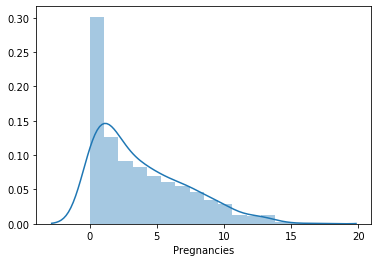

Glucose distribution


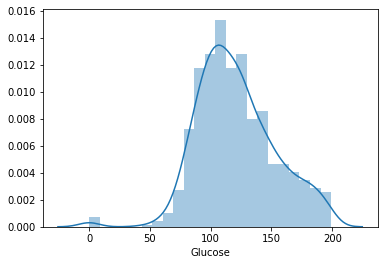

BloodPressure distribution


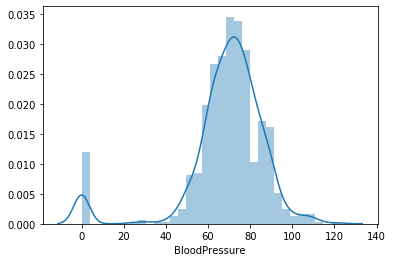

SkinThickness distribution


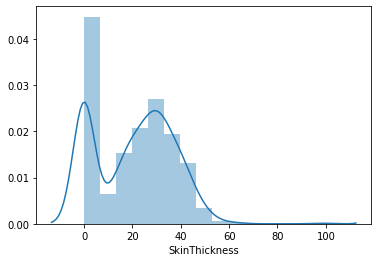

Insulin distribution


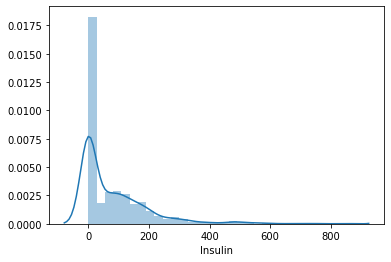

BMI distribution


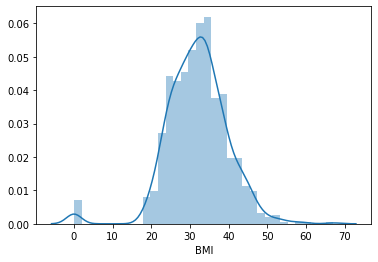

DiabetesPedigreeFunction distribution


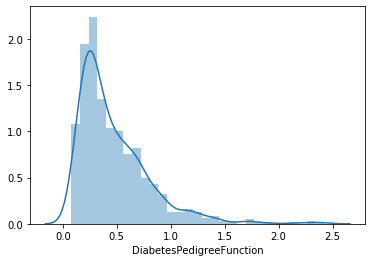

Age distribution


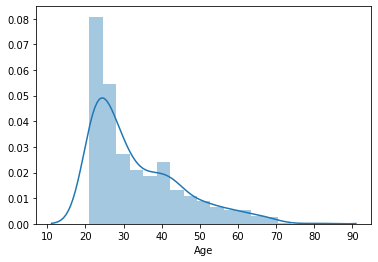

In [6]:
for feature in features:
    print("{} distribution".format(feature))
    sns.distplot(data['{}'.format(feature)])
    plt.show()
    

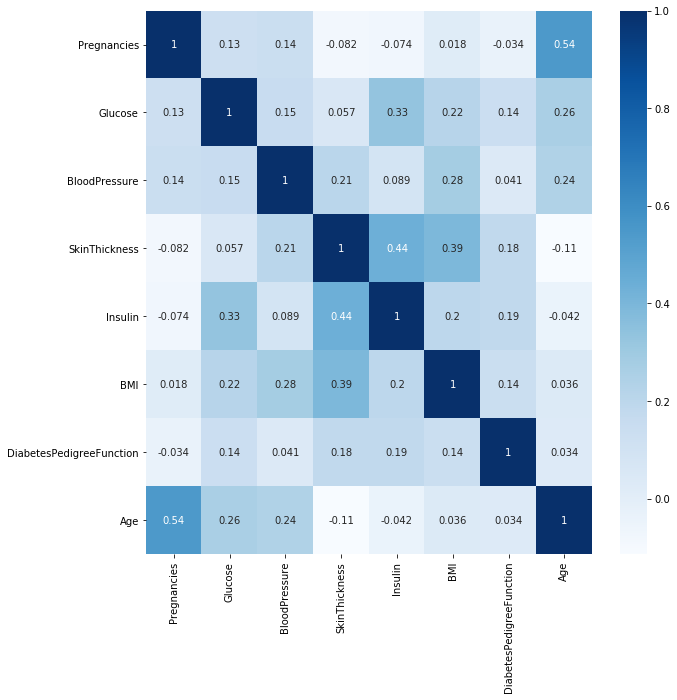

In [7]:
plt.figure(figsize=(10,10))
sns.heatmap(data[features].corr(),annot=True, cmap='Blues')

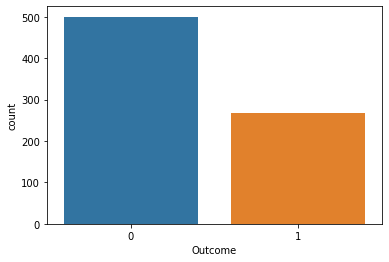

In [8]:
sns.countplot(data['Outcome'])

In [9]:
#taget 분리

In [10]:
label = data['Outcome']
data = data[features]

In [11]:
#0값을 np.nan으로 대체(Pregnancies(임신횟수) 제외)

In [12]:
data = data.replace(0,np.nan)

In [13]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6.0,148.0,72.0,35.0,NaN,33.6,0.627,50
1,1.0,85.0,66.0,29.0,NaN,26.6,0.351,31
2,8.0,183.0,64.0,NaN,NaN,23.3,0.672,32
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21
4,NaN,137.0,40.0,35.0,168.0,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63
764,2.0,122.0,70.0,27.0,NaN,36.8,0.340,27
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30
766,1.0,126.0,60.0,NaN,NaN,30.1,0.349,47


In [14]:
#train, valid(80%)  와 test(20%) 분리  (stratify=label)

In [15]:
from sklearn.model_selection import train_test_split
x_data, x_test, y_data, y_test = train_test_split(data,label, test_size=0.2,random_state=2021,shuffle=True,stratify=label)

In [16]:
#결측치를 평균으로 대체

In [17]:
x_data = x_data.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)

In [18]:
x_mean = np.mean(x_data[features],axis=0)

In [19]:
for c in features:
    x_data.loc[pd.isna(x_data[c]),c] = x_mean[c]
    x_test.loc[pd.isna(x_test[c]),c] = x_mean[c]

In [20]:
#결측치 확인

In [21]:
pd.isna(x_data).sum(), pd.isna(x_test).sum()

(Pregnancies                 0
 Glucose                     0
 BloodPressure               0
 SkinThickness               0
 Insulin                     0
 BMI                         0
 DiabetesPedigreeFunction    0
 Age                         0
 dtype: int64,
 Pregnancies                 0
 Glucose                     0
 BloodPressure               0
 SkinThickness               0
 Insulin                     0
 BMI                         0
 DiabetesPedigreeFunction    0
 Age                         0
 dtype: int64)

In [22]:
#변수 별 범위 설정

In [23]:
#age
bins = [0,29,39,64,120]
labels = ['youth', 'middle', 'middle_elder', 'elder']
x_data['Age'] = pd.cut(x_data.Age, bins, labels = labels, include_lowest = True)


In [24]:
x_test['Age'] = pd.cut(x_test.Age, bins, labels = labels, include_lowest = True)

In [25]:
#Glucose
bins = [0,100,126,300]
labels = ['normal_G','light_diabetes_G','diabetes_G']
x_data['Glucose'] = pd.cut(x_data.Glucose, bins, labels = labels, include_lowest = True)


In [26]:
x_test['Glucose'] = pd.cut(x_test.Glucose, bins, labels = labels, include_lowest = True)

In [27]:
#Bloodpressure
bins = [0,60,80,90,200]
labels = ['low_BP','normal_BP','light_diabetes_BP','diabetes_BP']
x_data['BloodPressure'] = pd.cut(x_data.BloodPressure, bins, labels = labels, include_lowest = True)

In [28]:
x_test['BloodPressure'] = pd.cut(x_test.BloodPressure, bins, labels = labels, include_lowest = True)

In [29]:
#BMI
bins=[0,18.5,23,25,30,100]
labels = ['underweight_bmi','normal_bmi','overweight_bmi','obese_bmi','clinically_obese_bmi']
x_data['BMI'] = pd.cut(x_data.BMI, bins, labels = labels, include_lowest = True)

In [30]:
x_test['BMI'] = pd.cut(x_test.BMI, bins, labels = labels, include_lowest = True)

In [31]:
x_data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1.000000,diabetes_G,diabetes_BP,41.000000,58.000000,clinically_obese_bmi,1.321,middle
1,9.000000,diabetes_G,normal_BP,29.184332,156.865385,clinically_obese_bmi,0.652,middle_elder
2,9.000000,normal_G,normal_BP,37.000000,156.865385,clinically_obese_bmi,0.096,middle_elder
3,9.000000,diabetes_G,normal_BP,31.000000,156.865385,clinically_obese_bmi,0.403,middle_elder
4,7.000000,light_diabetes_G,normal_BP,29.184332,156.865385,obese_bmi,0.209,middle
...,...,...,...,...,...,...,...,...
609,3.000000,normal_G,normal_BP,29.184332,156.865385,clinically_obese_bmi,0.174,youth
610,4.469349,light_diabetes_G,normal_BP,30.000000,165.000000,clinically_obese_bmi,0.203,middle
611,4.469349,normal_G,low_BP,29.184332,156.865385,clinically_obese_bmi,0.263,youth
612,3.000000,normal_G,normal_BP,30.000000,106.000000,clinically_obese_bmi,0.591,youth


In [32]:
x_test

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,9.000000,diabetes_G,light_diabetes_BP,28.000000,155.000000,clinically_obese_bmi,1.189,middle_elder
1,3.000000,light_diabetes_G,normal_BP,13.000000,48.000000,normal_bmi,0.678,youth
2,5.000000,light_diabetes_G,normal_BP,29.184332,156.865385,clinically_obese_bmi,0.261,middle_elder
3,1.000000,diabetes_G,diabetes_BP,28.000000,140.000000,clinically_obese_bmi,0.234,middle_elder
4,1.000000,normal_G,normal_BP,18.000000,59.000000,obese_bmi,1.268,youth
...,...,...,...,...,...,...,...,...
149,4.469349,normal_G,normal_BP,26.000000,50.000000,clinically_obese_bmi,0.597,youth
150,1.000000,light_diabetes_G,normal_BP,29.000000,180.000000,clinically_obese_bmi,0.496,youth
151,8.000000,light_diabetes_G,normal_BP,29.184332,156.865385,obese_bmi,0.237,middle_elder
152,2.000000,normal_G,low_BP,22.000000,115.000000,obese_bmi,1.699,youth


In [33]:
#연속형 범주형 데이터 구분

In [34]:
num_columns = ['Pregnancies','SkinThickness','Insulin','DiabetesPedigreeFunction']
cat_columns = [c for c in x_data.columns if c not in num_columns]

In [35]:
#연속형 변수의 one-hot-encoding 실시
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse =False)

In [36]:
#x_data

In [37]:
x_data_cat = ohe.fit_transform(x_data[cat_columns])

In [38]:
ohe_columns = ohe.categories_[0].tolist() + ohe.categories_[1].tolist() + ohe.categories_[2].tolist() + ohe.categories_[3].tolist()

In [39]:
x_data_cat = pd.DataFrame(x_data_cat,columns=ohe_columns)
x_data_cat

,diabetes_G,light_diabetes_G,normal_G,diabetes_BP,light_diabetes_BP,low_BP,normal_BP,clinically_obese_bmi,normal_bmi,obese_bmi,overweight_bmi,underweight_bmi,elder,middle,middle_elder,youth
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
610,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
611,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
612,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [40]:
x_data = pd.concat([x_data[num_columns], x_data_cat],axis=1)

In [41]:
x_data

,Pregnancies,SkinThickness,Insulin,DiabetesPedigreeFunction,diabetes_G,light_diabetes_G,normal_G,diabetes_BP,light_diabetes_BP,low_BP,normal_BP,clinically_obese_bmi,normal_bmi,obese_bmi,overweight_bmi,underweight_bmi,elder,middle,middle_elder,youth
0,1.000000,41.000000,58.000000,1.321,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,9.000000,29.184332,156.865385,0.652,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,9.000000,37.000000,156.865385,0.096,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,9.000000,31.000000,156.865385,0.403,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,7.000000,29.184332,156.865385,0.209,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,3.000000,29.184332,156.865385,0.174,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
610,4.469349,30.000000,165.000000,0.203,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
611,4.469349,29.184332,156.865385,0.263,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
612,3.000000,30.000000,106.000000,0.591,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [42]:
#x_test

In [43]:
x_test_cat = ohe.fit_transform(x_test[cat_columns])

In [44]:
x_test_cat = pd.DataFrame(x_test_cat,columns=ohe_columns)

In [45]:
x_test_cat

,diabetes_G,light_diabetes_G,normal_G,diabetes_BP,light_diabetes_BP,low_BP,normal_BP,clinically_obese_bmi,normal_bmi,obese_bmi,overweight_bmi,underweight_bmi,elder,middle,middle_elder,youth
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
150,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
151,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
152,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [46]:
x_test = pd.concat([x_test[num_columns], x_test_cat],axis=1)

In [47]:
x_test

,Pregnancies,SkinThickness,Insulin,DiabetesPedigreeFunction,diabetes_G,light_diabetes_G,normal_G,diabetes_BP,light_diabetes_BP,low_BP,normal_BP,clinically_obese_bmi,normal_bmi,obese_bmi,overweight_bmi,underweight_bmi,elder,middle,middle_elder,youth
0,9.000000,28.000000,155.000000,1.189,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3.000000,13.000000,48.000000,0.678,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,5.000000,29.184332,156.865385,0.261,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.000000,28.000000,140.000000,0.234,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.000000,18.000000,59.000000,1.268,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,4.469349,26.000000,50.000000,0.597,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
150,1.000000,29.000000,180.000000,0.496,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
151,8.000000,29.184332,156.865385,0.237,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
152,2.000000,22.000000,115.000000,1.699,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [48]:
#사용할 변수 선택 위해 간단한 모델 생성(lgb 성능이 더 좋게 나와)

In [49]:
x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, 
                                                      test_size=0.3,
                                                      random_state=2021,
                                                      shuffle=True,
                                                      stratify=y_data)

In [50]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier()

In [51]:
lgb.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], eval_metric= 'auc', verbose= 100, 
                early_stopping_rounds= 100)

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.999522	training's binary_logloss: 0.124947	valid_1's auc: 0.791516	valid_1's binary_logloss: 0.618802
Did not meet early stopping. Best iteration is:
[97]	training's auc: 0.99957	training's binary_logloss: 0.129451	valid_1's auc: 0.79087	valid_1's binary_logloss: 0.613899


LGBMClassifier()

In [52]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

In [53]:
y_pred = lgb.predict(x_valid)

In [54]:
print('Accuracy : {:.3f}'.format(accuracy_score(y_valid, y_pred)))
print('F1 Score: {:.3f}'.format(f1_score(y_valid, y_pred)))
print('AUC : {:.3f}'.format(roc_auc_score(y_valid, y_pred)))

Accuracy : 0.719
F1 Score: 0.559
AUC : 0.671


In [55]:
lgb.feature_importances_

array([284, 213, 136, 583,  58,  26,  28,   1,  32,   6,  46,  62,   2,
        31,   6,   0,   0,   9,  23,  56])

In [56]:
importances = pd.DataFrame({'feature': x_train.columns, 'importance': lgb.feature_importances_})
importances = importances.sort_values(by='importance',ascending=False)
importances.reset_index(drop=True, inplace=True)
importances

,feature,importance
0,DiabetesPedigreeFunction,583
1,Pregnancies,284
2,SkinThickness,213
3,Insulin,136
4,clinically_obese_bmi,62
5,diabetes_G,58
6,youth,56
7,normal_BP,46
8,light_diabetes_BP,32
9,obese_bmi,31


In [57]:
#사용할 변수 선택

In [58]:
importances['feature'].tolist()

['DiabetesPedigreeFunction',
 'Pregnancies',
 'SkinThickness',
 'Insulin',
 'clinically_obese_bmi',
 'diabetes_G',
 'youth',
 'normal_BP',
 'light_diabetes_BP',
 'obese_bmi',
 'normal_G',
 'light_diabetes_G',
 'middle_elder',
 'middle',
 'low_BP',
 'overweight_bmi',
 'normal_bmi',
 'diabetes_BP',
 'underweight_bmi',
 'elder']

In [59]:
using_features = ['DiabetesPedigreeFunction',
 'Pregnancies',
 'SkinThickness',
 'Insulin',
 'clinically_obese_bmi',
 'diabetes_G',
 'youth',
 'normal_BP',
 'light_diabetes_BP',
 'obese_bmi',
 'normal_G',
 'light_diabetes_G',
 'middle_elder']

In [60]:
#using_features에 해당하는 x_data, x_test 불러오기

In [61]:
x_data = x_data[using_features]
x_data

,DiabetesPedigreeFunction,Pregnancies,SkinThickness,Insulin,clinically_obese_bmi,diabetes_G,youth,normal_BP,light_diabetes_BP,obese_bmi,normal_G,light_diabetes_G,middle_elder
0,1.321,1.000000,41.000000,58.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.652,9.000000,29.184332,156.865385,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.096,9.000000,37.000000,156.865385,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.403,9.000000,31.000000,156.865385,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.209,7.000000,29.184332,156.865385,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,0.174,3.000000,29.184332,156.865385,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
610,0.203,4.469349,30.000000,165.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
611,0.263,4.469349,29.184332,156.865385,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
612,0.591,3.000000,30.000000,106.000000,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [62]:
x_test = x_test[using_features]
x_test

,DiabetesPedigreeFunction,Pregnancies,SkinThickness,Insulin,clinically_obese_bmi,diabetes_G,youth,normal_BP,light_diabetes_BP,obese_bmi,normal_G,light_diabetes_G,middle_elder
0,1.189,9.000000,28.000000,155.000000,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.678,3.000000,13.000000,48.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.261,5.000000,29.184332,156.865385,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,0.234,1.000000,28.000000,140.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.268,1.000000,18.000000,59.000000,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,0.597,4.469349,26.000000,50.000000,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
150,0.496,1.000000,29.000000,180.000000,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
151,0.237,8.000000,29.184332,156.865385,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
152,1.699,2.000000,22.000000,115.000000,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0


In [63]:
#target 라벨링

In [64]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(y_data)

In [65]:
#test

In [66]:
x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, 
                                                      test_size=0.3,
                                                      random_state=2021,
                                                      shuffle=True,
                                                      stratify=y_data)

In [67]:
lgb.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], eval_metric= 'auc', verbose= 100, 
                early_stopping_rounds= 100)

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.999642	training's binary_logloss: 0.127302	valid_1's auc: 0.772921	valid_1's binary_logloss: 0.648993
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.999642	training's binary_logloss: 0.127302	valid_1's auc: 0.772921	valid_1's binary_logloss: 0.648993


LGBMClassifier()

In [68]:
#모델학습 시작

In [69]:
#데이터 분리

In [70]:
from sklearn.model_selection import train_test_split


x_train, x_valid, y_train, y_valid = train_test_split(x_data, label, 
                                                      test_size=0.3,
                                                      random_state=2021,
                                                      shuffle=True,
                                                      stratify=label)

In [71]:
#BayesianOptimization

In [72]:
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score

In [73]:
# parameter 별로 search할 범위를 설정. 
bayesian_params = {
    'max_depth': (6, 16), 
    'num_leaves': (24, 64), 
    'min_child_samples': (10, 200), 
    'min_child_weight':(1, 50),
    'subsample':(0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'max_bin':(10, 500)
}

In [74]:
def lgb_roc_eval(max_depth, num_leaves, min_child_samples, min_child_weight, subsample, 
                colsample_bytree,max_bin):
    params = {
        "n_estimators":500, "learning_rate":0.01,
        'max_depth': int(round(max_depth)), #  호출 시 실수형 값이 들어오므로 정수형 하이퍼 파라미터는 정수형으로 변경 
        'num_leaves': int(round(num_leaves)), 
        'min_child_samples': int(round(min_child_samples)),
        'min_child_weight': int(round(min_child_weight)),
        'subsample': max(min(subsample, 1), 0), 
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'max_bin':  max(int(round(max_bin)),10)
    }
    lgb_model = LGBMClassifier(**params)
    lgb_model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], eval_metric= 'auc', verbose= 100, 
                early_stopping_rounds= 100)
    valid_proba = lgb_model.predict_proba(x_valid)[:, 1]
    roc_auc = roc_auc_score(y_valid, valid_proba)
    
    return roc_auc   

In [75]:
# BayesianOptimization객체를 수행할 함수와 search할 parameter 범위를 설정하여 생성. 
lgbBO = BayesianOptimization(lgb_roc_eval,bayesian_params , random_state=2021)
# 함수 반환값이 최대가 되는 입력값 유추를 위한 iteration 수행. 
lgbBO.maximize(init_points=5, n_iter=25)

|   iter    |  target   | colsam... |  max_bin  | max_depth | min_ch... | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.5	training's binary_logloss: 0.687876	valid_1's auc: 0.5	valid_1's binary_logloss: 0.683278
Early stopping, best iteration is:
[1]	training's auc: 0.5	training's binary_logloss: 0.687876	valid_1's auc: 0.5	valid_1's binary_logloss: 0.683278
|  1        |  0.5      |  0.803    |  369.4    |  7.389    |  69.41    |  49.86    |  29.13    |  0.5895   |
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.886368	training's binary_logloss: 0.470873	valid_1's auc: 0.767756	valid_1's binary_logloss: 0.547401
[200]	training's auc: 0.903345	training's binary_logloss: 0.405406	valid_1's auc: 0.773179	valid_1's binary_logloss: 0.535792
[300]	training's auc: 0.92602

In [76]:
# BayesianOptimization객체의 res는 iteration 수행 시마다 모든 함수 반환결과와 그때의 파라미터 결과값을 가지고 있음. 
lgbBO.res

[{'target': 0.5,
  'params': {'colsample_bytree': 0.8029891394037023,
   'max_bin': 369.3509869848141,
   'max_depth': 7.389471567283987,
   'min_child_samples': 69.40788593239051,
   'min_child_weight': 49.864920785675615,
   'num_leaves': 29.126495016758426,
   'subsample': 0.589496552975094}},
 {'target': 0.7792484504132231,
  'params': {'colsample_bytree': 0.8764627143880469,
   'max_bin': 334.4586520116717,
   'max_depth': 13.843101321411226,
   'min_child_samples': 28.409935225723554,
   'min_child_weight': 3.869992969313764,
   'num_leaves': 62.495839608415665,
   'subsample': 0.8082787219472871}},
 {'target': 0.6868543388429752,
  'params': {'colsample_bytree': 0.5433149806242736,
   'max_bin': 285.02345762509634,
   'max_depth': 12.165247086179901,
   'min_child_samples': 193.1301743463701,
   'min_child_weight': 29.140910428278865,
   'num_leaves': 38.84643392631126,
   'subsample': 0.7260726218947822}},
 {'target': 0.756198347107438,
  'params': {'colsample_bytree': 0.600925

In [77]:
# dictionary에 있는 target값을 모두 추출
target_list = []
for result in lgbBO.res:
    target = result['target']
    target_list.append(target)
print(target_list)
# 가장 큰 target 값을 가지는 순번(index)를 추출
print('maximum target index:', np.argmax(np.array(target_list)))

[0.5, 0.7792484504132231, 0.6868543388429752, 0.756198347107438, 0.707838326446281, 0.7693698347107438, 0.792161673553719, 0.7704674586776861, 0.7095170454545454, 0.7887396694214875, 0.6596074380165289, 0.7883522727272728, 0.7721461776859504, 0.7725335743801653, 0.5, 0.7835098140495868, 0.7702737603305786, 0.7911286157024793, 0.656379132231405, 0.7776342975206612, 0.584323347107438, 0.7698863636363636, 0.5, 0.7769240702479339, 0.7667871900826447, 0.6907928719008265, 0.584323347107438, 0.5, 0.7742768595041322, 0.7747933884297521]
maximum target index: 6


In [78]:
# 가장 큰 target값을 가지는 index값을 기준으로 res에서 해당 parameter 추출. 
max_dict = lgbBO.res[np.argmax(np.array(target_list))]
print(max_dict)

{'target': 0.792161673553719, 'params': {'colsample_bytree': 0.8136924445266152, 'max_bin': 296.9371730955792, 'max_depth': 13.038905783186882, 'min_child_samples': 66.41794003435027, 'min_child_weight': 1.0, 'num_leaves': 63.78232016032624, 'subsample': 1.0}}


In [79]:
params = {
        "n_estimators":500, "learning_rate":0.01,
        'max_depth': 13, #  호출 시 실수형 값이 들어오므로 정수형 하이퍼 파라미터는 정수형으로 변경 
        'num_leaves': 64, 
        'min_child_samples': 66,
        'min_child_weight': 1.0,
        'subsample': 1.0, 
        'colsample_bytree': 0.81,
        'max_bin': 296
    }
model = LGBMClassifier(**params)
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], eval_metric= 'auc', verbose= 100, 
                early_stopping_rounds= 100)

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.850311	training's binary_logloss: 0.509921	valid_1's auc: 0.756198	valid_1's binary_logloss: 0.560748
[200]	training's auc: 0.864098	training's binary_logloss: 0.460713	valid_1's auc: 0.777763	valid_1's binary_logloss: 0.532628
[300]	training's auc: 0.87374	training's binary_logloss: 0.437153	valid_1's auc: 0.784607	valid_1's binary_logloss: 0.523894
[400]	training's auc: 0.879881	training's binary_logloss: 0.423586	valid_1's auc: 0.788546	valid_1's binary_logloss: 0.522099
[500]	training's auc: 0.886858	training's binary_logloss: 0.411059	valid_1's auc: 0.792162	valid_1's binary_logloss: 0.522286
Did not meet early stopping. Best iteration is:
[500]	training's auc: 0.886858	training's binary_logloss: 0.411059	valid_1's auc: 0.792162	valid_1's binary_logloss: 0.522286


LGBMClassifier(colsample_bytree=0.81, learning_rate=0.01, max_bin=296,
               max_depth=13, min_child_samples=66, min_child_weight=1.0,
               n_estimators=500, num_leaves=64)

In [80]:
y_pred = model.predict(x_valid)

In [81]:
print('Accuracy : {:.3f}'.format(accuracy_score(y_valid, y_pred)))
print('F1 Score: {:.3f}'.format(f1_score(y_valid, y_pred)))
print('AUC : {:.3f}'.format(roc_auc_score(y_valid, y_pred)))

Accuracy : 0.735
F1 Score: 0.566
AUC : 0.680


In [86]:
#OOF 적용

In [82]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2021)

In [83]:
from sklearn.metrics import accuracy_score

In [84]:
accuracy_scores = list()
f1_scores = list()
auc_scores = list()


for i, (trn_idx, val_idx) in enumerate(skf.split(x_data, label)):
    x_train, y_train = x_data.iloc[trn_idx, :], label[trn_idx]
    x_valid, y_valid = x_data.iloc[val_idx, :], label[val_idx]
    
    
    
    params = {
        "n_estimators":500, "learning_rate":0.01,
        'max_depth': 13, #  호출 시 실수형 값이 들어오므로 정수형 하이퍼 파라미터는 정수형으로 변경 
        'num_leaves': 64, 
        'min_child_samples': 66,
        'min_child_weight': 1.0,
        'subsample': 1.0, 
        'colsample_bytree': 0.81,
        'max_bin': 296
    }
    model = LGBMClassifier(**params)
    
    model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_valid, y_valid)], eval_metric= 'auc', verbose= 100, 
                early_stopping_rounds= 100)

    # 훈련, 검증 데이터 Log Loss 확인
    val_accuracy = accuracy_score(y_valid, model.predict(x_valid))
    f1_accuracy = f1_score(y_valid, model.predict(x_valid))
    auc_accuracy = roc_auc_score(y_valid, model.predict(x_valid))
    accuracy_scores.append(val_accuracy)
    f1_scores.append(f1_accuracy)
    auc_scores.append(auc_accuracy)
    
    
   
    

# 교차 검증 Log Loss 평균 계산하기
print('accuracy Score : {:.4f}'.format(np.mean(accuracy_scores)))
print('f1 Score : {:.4f}'.format(np.mean(f1_scores)))
print('auc Score : {:.4f}'.format(np.mean(auc_scores)))

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.83686	training's binary_logloss: 0.525373	valid_1's auc: 0.842442	valid_1's binary_logloss: 0.514199
Early stopping, best iteration is:
[83]	training's auc: 0.831076	training's binary_logloss: 0.539119	valid_1's auc: 0.848256	valid_1's binary_logloss: 0.524404
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.838907	training's binary_logloss: 0.518656	valid_1's auc: 0.788953	valid_1's binary_logloss: 0.552776
[200]	training's auc: 0.853628	training's binary_logloss: 0.4738	valid_1's auc: 0.817006	valid_1's binary_logloss: 0.516368
[300]	training's auc: 0.862482	training's binary_logloss: 0.451662	valid_1's auc: 0.812791	valid_1's binary_logloss: 0.50691
Early stopping, best iteration is:
[215]	training's auc: 0.854861	training's binary_logloss: 0.469684	valid_1's auc: 0.817587	valid_1's binary_logloss: 0.513511
Training until validation scores don't improve for 100 

In [85]:
print('accuracy Score : {:.4f}'.format(np.mean(accuracy_scores)))
print('f1 Score : {:.4f}'.format(np.mean(f1_scores)))
print('auc Score : {:.4f}'.format(np.mean(auc_scores)))

accuracy Score : 0.7590
f1 Score : 0.5897
auc Score : 0.6990
